<a href="https://colab.research.google.com/github/bimal-bp/Water_Quality__Project/blob/main/waterquality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Number of Datasets:**

Sentinel-2 (COPERNICUS/S2_SR)

Landsat 8 (LANDSAT/LC08/C02/T1_L2)

Sentinel-3 OLCI (COPERNICUS/S3/OLCI)

In [ ]:
import ee

# Initialize the Earth Engine API
ee.Initialize()

# Access the LANDSAT/LC08/C02/T1_L2 collection
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Count the total number of images
image_count = collection.size().getInfo()

# Print the count
print(f"Number of images in the collection: {image_count}")


Number of images in the collection: 1804913


In [ ]:
# Filter by date range and region (example: January 2021 to December 2021 in a specific region)
filtered_collection = collection.filterDate('2018-01-01', '2024-12-31') \
                                .filterBounds(ee.Geometry.Point([72.6026, 23.0063]))  # Example coordinates

# Get the number of images after filtering
filtered_count = filtered_collection.size().getInfo()
print(f"Number of images after filtering: {filtered_count}")


Number of images after filtering: 279


In [ ]:
import ee

# Initialize the Earth Engine API
ee.Initialize()

# Define the start and end dates for the year 2024
start_date = '2024-01-01'
end_date = '2024-12-31'

# Access the LANDSAT/LC08/C02/T1_L2 collection and filter by date range
collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate(start_date, end_date)

# Count the total number of images in 2024
image_count = collection.size().getInfo()

# Print the count
print(f"Number of images in the collection for 2024: {image_count}")


/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Number of images in the collection for 2024: 4292912


In [ ]:
import ee

# Initialize the Earth Engine API
ee.Initialize()

# Define the start and end dates for the year 2024
start_date = '2024-01-01'
end_date = '2024-12-31'

# Access the LANDSAT/LC08/C02/T1_L2 collection and filter by date range
collection = ee.ImageCollection('COPERNICUS/S3/OLCI') \
    .filterDate(start_date, end_date)

# Count the total number of images in 2024
image_count = collection.size().getInfo()

# Print the count
print(f"Number of images in the collection for 2024: {image_count}")


Number of images in the collection for 2024: 136297


In [ ]:
import ee
import numpy as np

# Initialize Earth Engine
ee.Initialize()

def get_selected_data(image, geometry):
    # Calculate pH using the formula
    pH = ee.Image(8.339).subtract(ee.Image(0.827).multiply(image.select('B1').divide(image.select('B8')))).rename('pH')

    # Calculate DO using the formula
    dissolved_oxygen = ee.Image(-0.0167).multiply(image.select('B8')).add(ee.Image(0.0067).multiply(image.select('B9'))).add(ee.Image(0.0083).multiply(image.select('B11'))).add(ee.Image(9.577)).rename('dissolvedoxygen')

    # Calculate HUE: The color hue (simplified calculation from RGB bands)
    hue = image.select('B4').subtract(image.select('B3')).rename('hue')

    # Calculate FUI (Floating Unvegetated Index) using the formula NIR - Red
    fui = image.select('B8').subtract(image.select('B4')).rename('fui')

    # Mask non-water areas based on NDWI threshold (Water bodies only)
    ndwi = image.normalizedDifference(['B3', 'B8'])
    ndwi_masked = ndwi.updateMask(ndwi.gte(0.0))  # Lower threshold for testing

    # Apply cloud mask (QA60 band)
    cloud_mask = image.select('QA60').eq(0)  # 0 represents clear pixels, 1 represents clouds
    image = image.updateMask(cloud_mask)  # Apply the cloud mask to the image

    # Apply the mask to pH, DO, HUE, and FUI
    pH_masked = pH.updateMask(ndwi_masked)
    dissolved_oxygen_masked = dissolved_oxygen.updateMask(ndwi_masked)
    hue_masked = hue.updateMask(ndwi_masked)
    fui_masked = fui.updateMask(ndwi_masked)

    # Debug: Check if data exists in the region
    data_check = pH_masked.reduceRegion(
        reducer=ee.Reducer.count(),  # Count valid pixels in the region
        geometry=geometry,
        scale=30,
        maxPixels=10000
    )

    count = ee.Number(data_check.get('pH')).getInfo()

    if count == 0:
        print("No valid data in the region.")
        return None, None, None, None

    # Reduce region to get pixel values for pH, DO, HUE, and FUI
    pH_data = pH_masked.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=10000
    )
    do_data = dissolved_oxygen_masked.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=10000
    )
    hue_data = hue_masked.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=10000
    )
    fui_data = fui_masked.reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=30,
        maxPixels=10000
    )

    # Extract the data into arrays
    pH_values = np.array(ee.Array(pH_data.get('pH')).getInfo())
    do_values = np.array(ee.Array(do_data.get('dissolvedoxygen')).getInfo())
    hue_values = np.array(ee.Array(hue_data.get('hue')).getInfo())
    fui_values = np.array(ee.Array(fui_data.get('fui')).getInfo())

    # Check if all values are non-empty before returning
    if pH_values.size > 0 and do_values.size > 0 and hue_values.size > 0 and fui_values.size > 0:
        return pH_masked, dissolved_oxygen_masked, hue_masked, fui_masked
    else:
        print("No valid data in the region.")
        return None, None, None, None

# Example usage
geometry = ee.Geometry.Polygon([[[12.4920, 41.8900], [12.4920, 41.8910], [12.4930, 41.8910], [12.4930, 41.8900]]])  # Enlarged region

# Filter Sentinel-2 images for the year 2024
image_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(geometry) \
    .filterDate('2024-01-01', '2024-12-31')  # Filter images for the year 2024

# Limit to 700 images
image_collection = image_collection.limit(700)

# Debug: Check the count of images available
image_count = image_collection.size().getInfo()
print(f"Number of images available: {image_count}")

# Get the first image in the collection
image = image_collection.first()

if image.getInfo() is None:
    print("No images found or unavailable for the specified region and date range.")
else:
    print("Image loaded successfully!")
    # Call function to get selected data
    pH_data, DO_data, hue_data, fui_data = get_selected_data(image, geometry)

    if pH_data is not None and DO_data is not None and hue_data is not None and fui_data is not None:
        print("Data retrieved successfully!")
    else:
        print("Error retrieving data.")


Number of images available: 146
Image loaded successfully!
No valid data in the region.
Error retrieving data.


In [ ]:
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate('2014-01-01', '2024-12-31') \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))


In [ ]:
def calculate_indices(image):
    ndci = image.normalizedDifference(['B4', 'B8']).rename('NDCI')
    ndwi = image.normalizedDifference(['B3', 'B11']).rename('NDWI')
    return image.addBands([ndci, ndwi])
s2_indices = s2.map(calculate_indices)


In [ ]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define your region of interest (geometry) - replace with your coordinates
geometry = ee.Geometry.Polygon([
    [72.5986408493042, 23.006549566021803],
    [72.59902708740235, 23.004890477468116],
    [72.60070078582764, 23.003863412427236],
    [72.60040037841797, 23.007142092704626],
    [72.60215990753174, 23.006668071566512],
    [72.60173075408936, 23.003784407100333],
    [72.60366194458008, 23.00516699364359],
    [72.60374777526856, 23.00686558057643],
    [72.6026748916626, 23.00805062856477],
    [72.60082953186036, 23.00880115357416],
    [72.59945624084473, 23.00809012998513],
    [72.5986408493042, 23.006549566021803]
])

# Define the date range
start_date = '2010-01-01'
end_date = '2024-12-31'

# Initialize Landsat 8 Image Collection
landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(start_date, end_date) \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10))  # Adjust cloud cover threshold if necessary

# Function to calculate indices for Landsat 8
def calculate_indices_l8(image):
    # Corrected band names
    ndci = image.normalizedDifference(['SR_B4', 'SR_B5']).rename('NDCI')  # Chlorophyll index
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDWI')  # Water index
    return image.addBands([ndci, ndwi])

# Apply the function to Landsat 8 collection
l8_indices = landsat8.map(calculate_indices_l8)

# Reduce the region to extract statistics
def get_region_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=30,
        maxPixels=1e6
    )
    return ee.Feature(None, stats)

# Apply stats extraction
stats = l8_indices.map(get_region_stats)

# Convert the results to a Python-readable format (optional)
def extract_stats(stats):
    stats_dicts = [feature['properties'] for feature in stats.getInfo()['features']]
    import pandas as pd
    return pd.DataFrame(stats_dicts)

# Extract the stats into a DataFrame
data = extract_stats(stats)

# Display the DataFrame
print(data)

# Optionally save to a CSV file
data.to_csv('landsat8_indices.csv', index=False)


         NDCI      NDWI      QA_PIXEL  QA_RADSAT        SR_B1        SR_B2  \
0   -0.029695  0.063206  21824.909873          0  8034.675143  8546.000987   
1   -0.040631  0.031153  21824.000000          0  8355.439820  9145.100570   
2   -0.006668  0.080329  21951.311979          0  7901.537122  8329.041356   
3   -0.004553  0.092989  21951.677051          0  7984.182207  8396.239491   
4   -0.005639  0.091402  22644.035849          0  7813.992299  8207.257986   
..        ...       ...           ...        ...          ...          ...   
293  0.001478  0.087252  21951.781398          0  8162.757948  8678.223988   
294  0.014383  0.112519  21951.834647          0  8062.704129  8628.292367   
295  0.015296  0.088860  21951.843055          0  8149.878963  8657.775530   
296  0.011317  0.120047  23819.287791          0  8311.488133  9108.842967   
297  0.015163  0.080188  22672.497898          0  7919.873796  8395.545257   

            SR_B3         SR_B4         SR_B5         SR_B6  ..

In [ ]:
import pandas as pd
data2=pd.read_csv('/content/landsat8_indices.csv')

In [ ]:
data2.head()

,NDCI,NDWI,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,...,SR_QA_AEROSOL,ST_ATRAN,ST_B10,ST_CDIST,ST_DRAD,ST_EMIS,ST_EMSD,ST_QA,ST_TRAD,ST_URAD
0,-0.029695,0.063206,21824.909873,0,8034.675143,8546.000987,10118.764173,9388.701624,9963.896972,8916.642299,...,207.554892,6424.721479,47224.390654,6420.998596,1379.504783,9881.098881,93.434686,220.442760,9978.272137,2879.049627
1,-0.040631,0.031153,21824.000000,0,8355.439820,9145.100570,11122.298706,10581.173475,11477.826393,10450.829838,...,220.745283,7033.387165,47025.587714,11442.228806,1222.236836,9645.530584,93.434686,188.234708,10104.501141,2570.000000
2,-0.006668,0.080329,21951.311979,0,7901.537122,8329.041356,9613.867222,8832.347938,8951.480715,8184.840917,...,220.319789,7019.262462,45964.046358,2567.530869,1206.678675,9901.989381,93.434686,185.671457,9889.161496,2577.116125
3,-0.004553,0.092989,21951.677051,0,7984.182207,8396.239491,9611.514458,8858.208600,8939.407591,7976.254037,...,221.412462,6984.896819,45319.221588,18.670338,1175.000000,9903.401645,93.434686,529.874660,9560.554936,2510.716784
4,-0.005639,0.091402,22644.035849,0,7813.992299,8207.257986,9324.098069,8607.931395,8705.645722,7762.505924,...,221.565072,8811.394318,43814.110970,4.017003,486.000000,9903.472532,93.434686,559.246446,9188.838679,949.315336


In [ ]:
import ee
import pandas as pd

# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (geometry) - replace with your coordinates
geometry = ee.Geometry.Polygon([
    [72.5986408493042, 23.006549566021803],
    [72.59902708740235, 23.004890477468116],
    [72.60070078582764, 23.003863412427236],
    [72.60040037841797, 23.007142092704626],
    [72.60215990753174, 23.006668071566512],
    [72.60173075408936, 23.003784407100333],
    [72.60366194458008, 23.00516699364359],
    [72.60374777526856, 23.00686558057643],
    [72.6026748916626, 23.00805062856477],
    [72.60082953186036, 23.00880115357416],
    [72.59945624084473, 23.00809012998513],
    [72.5986408493042, 23.006549566021803]
])

# Define the date range
start_date = '2014-01-01'  # Sentinel-2 data starts in 2017
end_date = '2024-12-31'

# Load the Sentinel-2 Image Collection
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate(start_date, end_date) \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Adjust cloud cover filter as needed

# Function to calculate indices for Sentinel-2
def calculate_indices_s2(image):
    # NDCI: Red Edge (B5) and NIR (B8)
    ndci = image.normalizedDifference(['B5', 'B8']).rename('NDCI')
    # NDWI: Green (B3) and NIR (B8)
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands([ndci, ndwi])

# Apply the function to Sentinel-2 collection
s2_indices = s2.map(calculate_indices_s2)

# Reduce the region to extract mean statistics
def get_region_stats(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,  # Sentinel-2 has a finer resolution of 10 meters
        maxPixels=1e8
    )
    return ee.Feature(None, stats)

# Apply stats extraction
stats = s2_indices.map(get_region_stats)

# Convert the results to a DataFrame
def extract_stats(stats):
    stats_dicts = [feature['properties'] for feature in stats.getInfo()['features']]
    return pd.DataFrame(stats_dicts)

# Extract stats into a DataFrame
data_s2 = extract_stats(stats)

# Display and save the data
print("Sentinel-2 Indices Data:")
print(data_s2)

# Save to CSV
data_s2.to_csv('sentinel2_indices.csv', index=False)


Sentinel-2 Indices Data:
       AOT           B1          B11          B12           B2           B3  \
0    378.0  1204.521425  1258.467118  1231.605045  1313.224196  1652.972936   
1    378.0  1206.966897  1258.668651  1232.279114  1314.915082  1654.493643   
2    202.0   423.609907   203.396132   168.116601   455.765867   666.387929   
3    202.0   430.587420   203.440114   168.709810   459.395032   668.763719   
4    202.0   239.824671   108.567872    94.158003   358.179121   553.622529   
..     ...          ...          ...          ...          ...          ...   
495  252.0  1320.156953  1150.582123  1133.521398  1348.622312  1614.487946   
496  258.0  1313.664583  1173.210649  1141.040950  1352.907291  1631.257896   
497  234.0  1370.622322  1182.906849  1146.049183  1401.883409  1664.400434   
498  192.0  1244.487530  1111.400602  1104.408171  1346.411777  1585.207303   
499  204.0  1218.160615  1106.535062  1101.983923  1324.265408  1569.966514   

              B4          

In [ ]:
data2=pd.read_csv('/content/landsat8_indices.csv')

In [ ]:
data2.columns

Index(['NDCI', 'NDWI', 'QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_ATRAN',
       'ST_B10', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA',
       'ST_TRAD', 'ST_URAD'],
      dtype='object')

In [ ]:
data2.shape

(298, 21)

In [ ]:
data3=pd.read_csv('/content/sentinel2_indices.csv')
data3.head()

,AOT,B1,B11,B12,B2,B3,B4,B5,B6,B7,...,NDCI,NDWI,SCL,TCI_B,TCI_G,TCI_R,WVP,QA10,QA20,QA60
0,378.0,1204.521425,1258.467118,1231.605045,1313.224196,1652.972936,1386.834401,2246.353489,2031.192718,2044.648189,...,0.094234,-0.058889,5.986013,32.326010,66.828020,39.907394,1842.986381,NaN,NaN,NaN
1,378.0,1206.966897,1258.668651,1232.279114,1314.915082,1654.493643,1388.421647,2250.354402,2033.612634,2046.525272,...,0.094857,-0.058689,5.984111,32.479845,67.003782,40.135655,1876.649010,NaN,NaN,NaN
2,202.0,423.609907,203.396132,168.116601,455.765867,666.387929,460.054533,1032.163984,718.526036,700.254007,...,0.251366,0.038011,5.994243,46.899234,68.120565,47.306505,700.000000,0.0,0.0,0.0
3,202.0,430.587420,203.440114,168.709810,459.395032,668.763719,461.649324,1037.183319,721.187695,701.994830,...,0.253222,0.039342,5.998918,47.254947,68.394011,47.458934,742.000000,0.0,0.0,0.0
4,202.0,239.824671,108.567872,94.158003,358.179121,553.622529,312.557888,936.168108,615.795903,586.793286,...,0.293520,0.039215,5.999022,37.044080,56.707727,32.326620,454.000000,0.0,0.0,0.0


In [ ]:
data3.shape

(500, 28)

In [ ]:
data3.columns

Index(['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE',
       'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'NDCI', 'NDWI',
       'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP', 'QA10', 'QA20', 'QA60'],
      dtype='object')

In [ ]:
data3.columns = data3.columns.str.strip()  # Remove spaces
data3.columns = data3.columns.str.upper()  # Convert to uppercase for consistency
print(data3.columns)


Index(['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE',
       'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'NDCI', 'NDWI',
       'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP', 'QA10', 'QA20', 'QA60'],
      dtype='object')


In [ ]:
print("Columns in Landsat 8 dataset:", data3.columns)
print("Columns in Sentinel 2 dataset:", data2.columns)


Columns in Landsat 8 dataset: Index(['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE',
       'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'NDCI', 'NDWI',
       'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP', 'QA10', 'QA20', 'QA60'],
      dtype='object')
Columns in Sentinel 2 dataset: Index(['NDCI', 'NDWI', 'QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_ATRAN',
       'ST_B10', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA',
       'ST_TRAD', 'ST_URAD'],
      dtype='object')


In [ ]:
print(data2.shape)
print(data3.shape)

(298, 21)
(500, 28)


In [ ]:
data2.isnull().sum().sum()

0

In [ ]:
data3.isnull().sum()

,0
AOT,0
B1,0
B11,0
B12,0
B2,0
B3,0
B4,0
B5,0
B6,0
B7,0


In [ ]:
import numpy as np
import pandas as pd

# Load datasets
data1 = pd.read_csv('/content/landsat8_indices.csv')  # Replace with actual file path
data2 = pd.read_csv('/content/sentinel2_indices.csv')

# Ensure there are no conflicting column names before merging
common_columns = set(data1.columns) & set(data2.columns)
if common_columns:
    print(f"Common columns detected: {common_columns}")
    # Rename columns in the second dataset to avoid overwriting
    data2 = data2.rename(columns={col: f"{col}_s2" for col in common_columns})

# Merge datasets
data = pd.merge(data1, data2, left_index=True, right_index=True)

# Ensure required columns exist in the merged dataset
required_columns = {'NDCI', 'NDWI', 'ST_B10', 'TCI_R', 'TCI_G', 'TCI_B', 'B4', 'B5'}
missing_columns = required_columns - set(data.columns)

if missing_columns:
    raise KeyError(f"The following required columns are missing: {missing_columns}")

# Calculate pH (example formula)
def calculate_ph(row):
    a, b, c = 0.5, -0.2, 7.0  # Example coefficients
    return a * row['NDCI'] + b * row['NDWI'] + c

data['pH'] = data.apply(calculate_ph, axis=1)

# Calculate Dissolved Oxygen (DO)
def calculate_do(row):
    a, b, c = -0.3, 0.1, 8.0  # Example coefficients
    return a * row['NDWI'] + b * row['ST_B10'] + c

data['DO'] = data.apply(calculate_do, axis=1)

# Calculate Hue
def calculate_hue(row):
    R, G, B = row['TCI_R'], row['TCI_G'], row['TCI_B']
    return np.arctan2(np.sqrt(3) * (G - B), 2 * R - G - B)

data['Hue'] = data.apply(calculate_hue, axis=1)

# Calculate Floating Vegetation Index (FUI)
def calculate_fui(row):
    if row['B4'] != 0:  # Avoid division by zero
        return row['B5'] / row['B4']
    else:
        return np.nan

data['FUI'] = data.apply(calculate_fui, axis=1)

# Save the resulting dataset
output_file = 'calculated_parameters.csv'
data.to_csv(output_file, index=False)

print(f"Calculations completed and saved to '{output_file}'.")

Common columns detected: {'NDCI', 'NDWI'}
Calculations completed and saved to 'calculated_parameters.csv'.


In [ ]:
df=pd.read_csv('/content/calculated_parameters.csv')
df

,NDCI,NDWI,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,...,TCI_G,TCI_R,WVP,QA10,QA20,QA60,pH,DO,Hue,FUI
0,-0.029695,0.063206,21824.909873,0,8034.675143,8546.000987,10118.764173,9388.701624,9963.896972,8916.642299,...,66.828020,39.907394,1842.986381,NaN,NaN,NaN,6.972511,4730.420104,1.883779,1.619771
1,-0.040631,0.031153,21824.000000,0,8355.439820,9145.100570,11122.298706,10581.173475,11477.826393,10450.829838,...,67.003782,40.135655,1876.649010,NaN,NaN,NaN,6.973454,4710.549426,1.881670,1.620800
2,-0.006668,0.080329,21951.311979,0,7901.537122,8329.041356,9613.867222,8832.347938,8951.480715,8184.840917,...,68.120565,47.306505,700.000000,0.0,0.0,0.0,6.980600,4604.380537,2.077615,2.243569
3,-0.004553,0.092989,21951.677051,0,7984.182207,8396.239491,9611.514458,8858.208600,8939.407591,7976.254037,...,68.394011,47.458934,742.000000,0.0,0.0,0.0,6.979126,4539.894262,2.085998,2.246691
4,-0.005639,0.091402,22644.035849,0,7813.992299,8207.257986,9324.098069,8607.931395,8705.645722,7762.505924,...,56.707727,32.326620,454.000000,0.0,0.0,0.0,6.978900,4389.383676,2.277823,2.995183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.001478,0.087252,21951.781398,0,8162.757948,8678.223988,10014.740191,9228.734104,9202.078144,8408.188693,...,56.760873,29.531422,1215.275461,0.0,0.0,0.0,6.983289,4575.156899,1.915235,1.518316
294,0.014383,0.112519,21951.834647,0,8062.704129,8628.292367,10066.809073,9163.616811,8904.358951,8031.400267,...,63.662324,37.055005,1427.986405,0.0,0.0,0.0,6.984688,4616.891376,1.957948,1.484293
295,0.015296,0.088860,21951.843055,0,8149.878963,8657.775530,9898.516290,9188.603915,8912.396983,8283.730579,...,63.141951,36.281706,1429.981704,0.0,0.0,0.0,6.989876,4566.167724,1.958478,1.489756
296,0.011317,0.120047,23819.287791,0,8311.488133,9108.842967,10677.602754,10084.812226,9859.823984,8389.746168,...,62.222099,36.285604,1204.837930,0.0,0.0,0.0,6.981649,4389.274485,1.915565,1.490864


In [ ]:
df.shape

(298, 53)

In [ ]:
df.columns

Index(['NDCI', 'NDWI', 'QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3',
       'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_ATRAN',
       'ST_B10', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA',
       'ST_TRAD', 'ST_URAD', 'AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5',
       'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_OPAQUE',
       'MSK_CLASSI_SNOW_ICE', 'MSK_CLDPRB', 'MSK_SNWPRB', 'NDCI_s2', 'NDWI_s2',
       'SCL', 'TCI_B', 'TCI_G', 'TCI_R', 'WVP', 'QA10', 'QA20', 'QA60', 'pH',
       'DO', 'Hue', 'FUI'],
      dtype='object')

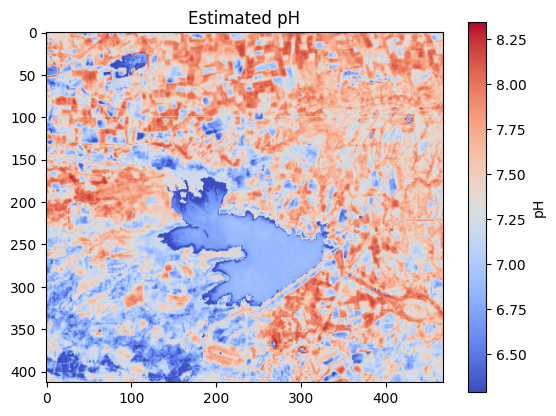

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the bands (or RGB image)
# Assume B1 is the Blue channel and B8 is derived or substituted
image = cv2.imread('/content/tappar_lake.png')
blue_band = image[:, :, 2]  # Blue channel (B1)
nir_band = np.ones_like(blue_band) * 100  # Substitute for NIR (example data)

# Avoid divide-by-zero
nir_band = np.clip(nir_band, 1, None)

# Calculate B1/B8 ratio
ratio = blue_band.astype(float) / nir_band

# Calculate pH using the formula
pH = 8.399 - 0.827 * ratio

# Visualize the pH map
plt.imshow(pH, cmap='coolwarm')
plt.colorbar(label='pH')
plt.title('Estimated pH')
plt.show()


Average pH of the water: 6.58


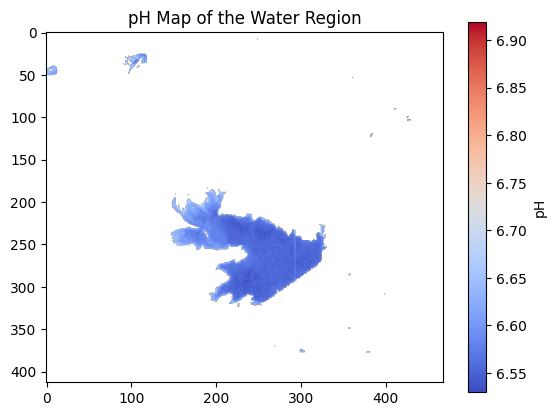

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/tappar_lake.png'
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for better color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the purple color range for water segmentation (adjust values as needed)
lower_purple = np.array([120, 50, 50])  # Lower HSV bound for purple
upper_purple = np.array([160, 255, 255])  # Upper HSV bound for purple

# Create a mask for the water region
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# Apply the mask to extract the blue channel (B1) from the water region
blue_band = image_rgb[:, :, 2]  # Blue channel
masked_blue = cv2.bitwise_and(blue_band, blue_band, mask=mask)

# Create a placeholder for the NIR band (B8) for the water region
nir_band = np.ones_like(masked_blue) * 100  # Substitute NIR band with a constant value

# Avoid divide-by-zero
nir_band = np.clip(nir_band, 1, None)

# Compute B1/B8 ratio
ratio = masked_blue.astype(float) / nir_band

# Apply the formula to calculate pH for the water region
pH = 8.399 - 0.827 * ratio

# Mask the non-water regions in the pH map
pH[mask == 0] = np.nan

# Calculate the average pH of the water region
average_pH = np.nanmean(pH)

# Display the results
print(f"Average pH of the water: {average_pH:.2f}")

# Visualize the pH map
plt.imshow(pH, cmap='coolwarm')
plt.colorbar(label='pH')
plt.title('pH Map of the Water Region')
plt.show()


Average pH of the water: 6.58
Average Hue of the water: 143.88
Average FUI of the water: -1.74


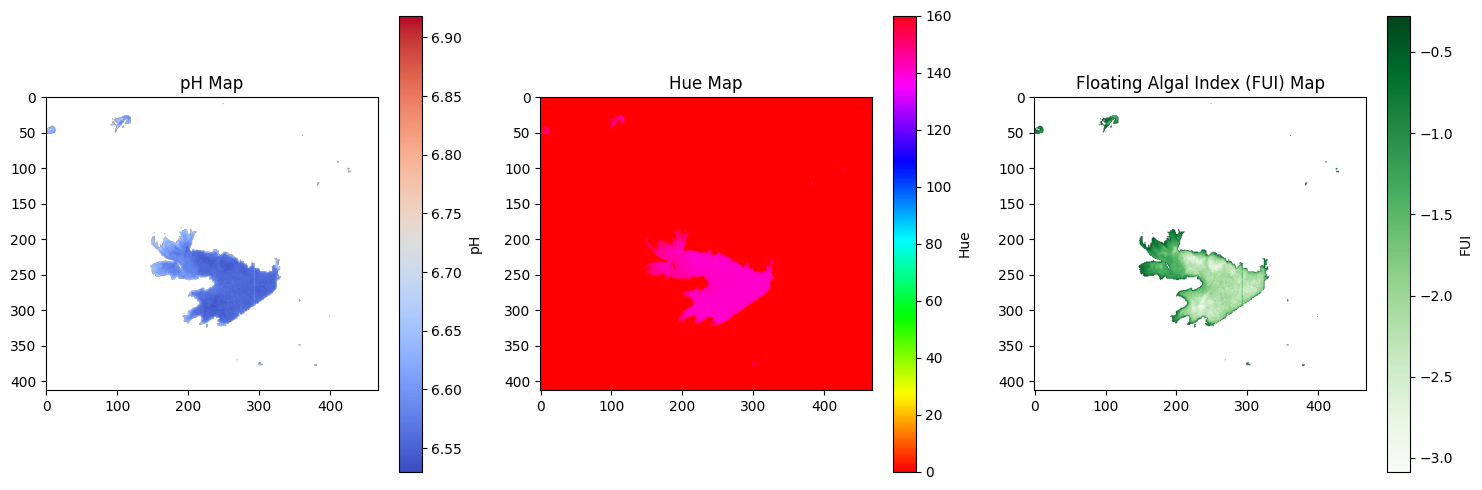

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/tappar_lake.png'
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for better color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the purple color range for water segmentation (adjust values as needed)
lower_purple = np.array([120, 50, 50])  # Lower HSV bound for purple
upper_purple = np.array([160, 255, 255])  # Upper HSV bound for purple

# Create a mask for the water region
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# 1. Calculate pH
blue_band = image_rgb[:, :, 2]  # Blue channel
nir_band = np.ones_like(blue_band) * 100  # Substitute NIR band with a constant value
nir_band = np.clip(nir_band, 1, None)  # Avoid divide-by-zero
ratio = blue_band.astype(float) / nir_band
pH = 8.399 - 0.827 * ratio
pH[mask == 0] = np.nan  # Mask non-water regions
average_pH = np.nanmean(pH)

# 2. Calculate Hue
hue = hsv_image[:, :, 0]  # Extract hue channel
masked_hue = cv2.bitwise_and(hue, hue, mask=mask)
average_hue = np.nanmean(masked_hue[mask != 0])

# 3. Calculate Floating Algal Index (FUI)
green_band = image_rgb[:, :, 1]  # Green channel
fui = (green_band.astype(float) - blue_band) / (green_band + blue_band + 1e-5)
fui[mask == 0] = np.nan  # Mask non-water regions
average_fui = np.nanmean(fui)

# Display the results
print(f"Average pH of the water: {average_pH:.2f}")
print(f"Average Hue of the water: {average_hue:.2f}")
print(f"Average FUI of the water: {average_fui:.2f}")

# Visualize the results
# pH Map
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(pH, cmap='coolwarm')
plt.colorbar(label='pH')
plt.title('pH Map')

# Hue Map
plt.subplot(1, 3, 2)
plt.imshow(masked_hue, cmap='hsv')
plt.colorbar(label='Hue')
plt.title('Hue Map')

# FUI Map
plt.subplot(1, 3, 3)
plt.imshow(fui, cmap='Greens')
plt.colorbar(label='FUI')
plt.title('Floating Algal Index (FUI) Map')

plt.tight_layout()
plt.show()


Average pH of the water: 6.58
Average Hue of the water: 143.88
Average FUI of the water: -1.74
Average DO of the water: 7.28


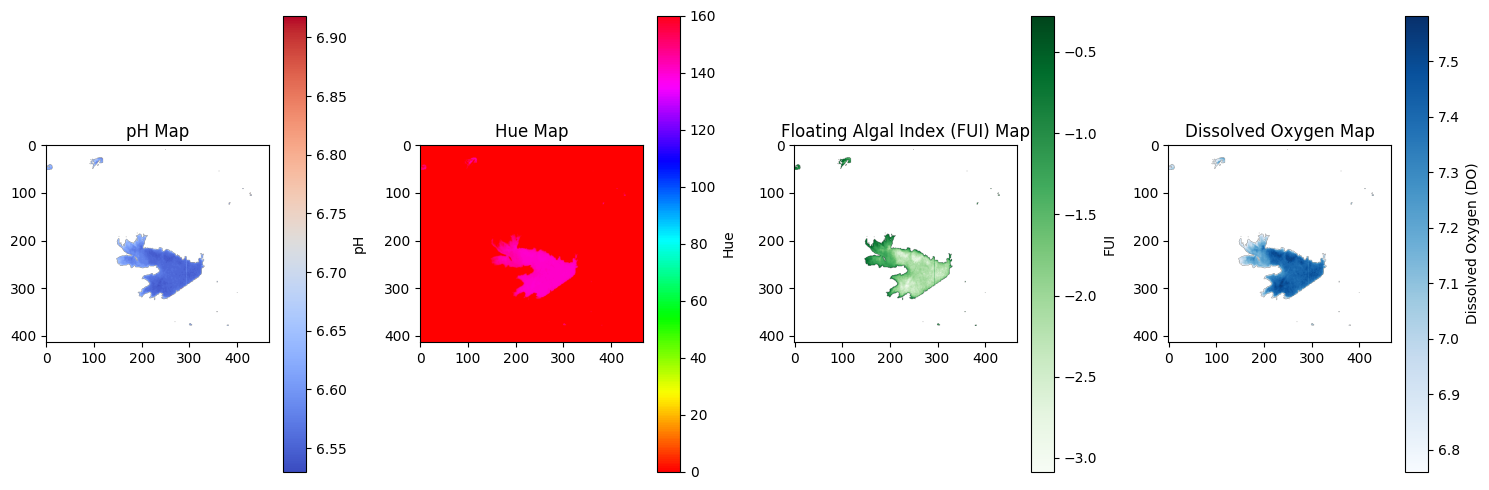

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/tappar_lake.png'
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for better color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the purple color range for water segmentation (adjust values as needed)
lower_purple = np.array([120, 50, 50])  # Lower HSV bound for purple
upper_purple = np.array([160, 255, 255])  # Upper HSV bound for purple

# Create a mask for the water region
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# 1. Calculate pH
blue_band = image_rgb[:, :, 2]  # Blue channel
nir_band = np.ones_like(blue_band) * 100  # Substitute NIR band with a constant value
nir_band = np.clip(nir_band, 1, None)  # Avoid divide-by-zero
ratio = blue_band.astype(float) / nir_band
pH = 8.399 - 0.827 * ratio
pH[mask == 0] = np.nan  # Mask non-water regions
average_pH = np.nanmean(pH)

# 2. Calculate Hue
hue = hsv_image[:, :, 0]  # Extract hue channel
masked_hue = cv2.bitwise_and(hue, hue, mask=mask)
average_hue = np.nanmean(masked_hue[mask != 0])

# 3. Calculate Floating Algal Index (FUI)
green_band = image_rgb[:, :, 1]  # Green channel
fui = (green_band.astype(float) - blue_band) / (green_band + blue_band + 1e-5)
fui[mask == 0] = np.nan  # Mask non-water regions
average_fui = np.nanmean(fui)

# 4. Calculate Dissolved Oxygen (DO)
# Using the empirical formula DO = a * (Blue/Red) + b
red_band = image_rgb[:, :, 0]  # Red channel
do_ratio = blue_band.astype(float) / (red_band + 1e-5)  # Avoid divide-by-zero
a, b = 2.0, 5.0  # Example coefficients (replace with actual values from calibration)
DO = a * do_ratio + b
DO[mask == 0] = np.nan  # Mask non-water regions
average_DO = np.nanmean(DO)

# Display the results
print(f"Average pH of the water: {average_pH:.2f}")
print(f"Average Hue of the water: {average_hue:.2f}")
print(f"Average FUI of the water: {average_fui:.2f}")
print(f"Average DO of the water: {average_DO:.2f}")

# Visualize the results
# pH Map
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(pH, cmap='coolwarm')
plt.colorbar(label='pH')
plt.title('pH Map')

# Hue Map
plt.subplot(1, 4, 2)
plt.imshow(masked_hue, cmap='hsv')
plt.colorbar(label='Hue')
plt.title('Hue Map')

# FUI Map
plt.subplot(1, 4, 3)
plt.imshow(fui, cmap='Greens')
plt.colorbar(label='FUI')
plt.title('Floating Algal Index (FUI) Map')

# DO Map
plt.subplot(1, 4, 4)
plt.imshow(DO, cmap='Blues')
plt.colorbar(label='Dissolved Oxygen (DO)')
plt.title('Dissolved Oxygen Map')

plt.tight_layout()
plt.show()


Average Hardness: 9.70 mg/L
Average Turbidity: 3.70 NTU
Average Organic Carbon: 3.18 ppm


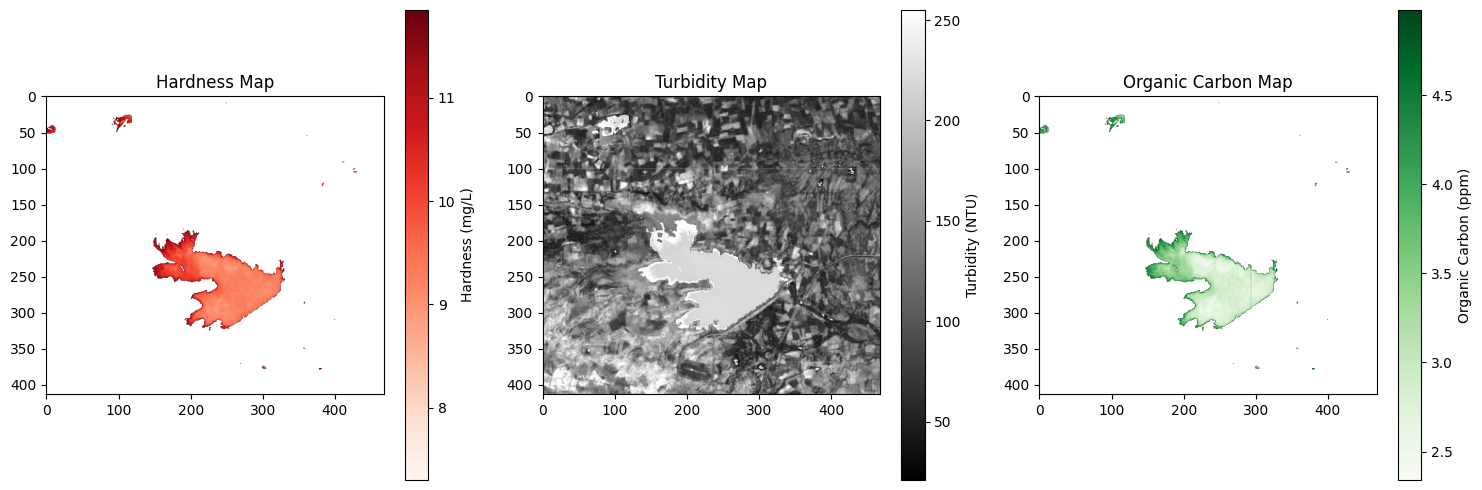

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/tappar_lake.png'  # Update the path to your image file
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB and HSV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a mask for water regions (adjust HSV range based on your data)
lower_purple = np.array([120, 50, 50])  # Adjust based on water color
upper_purple = np.array([160, 255, 255])
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# 1. Calculate Hardness (using the red channel as a proxy)
red_band = image_rgb[:, :, 0]
hardness = red_band.astype(float) * 0.05  # Scaling factor for demonstration
hardness[mask == 0] = np.nan  # Mask non-water regions
average_hardness = np.nanmean(hardness)

# 2. Calculate Turbidity (using variance in HSV Value channel)
value_channel = hsv_image[:, :, 2]  # Value channel from HSV
turbidity = np.std(value_channel[mask != 0])  # Standard deviation as a proxy for turbidity

# 3. Calculate Organic Carbon (using the green channel)
green_band = image_rgb[:, :, 1]
organic_carbon = green_band.astype(float) * 0.03  # Scaling factor for demonstration
organic_carbon[mask == 0] = np.nan
average_organic_carbon = np.nanmean(organic_carbon)

# Display the results
print(f"Average Hardness: {average_hardness:.2f} mg/L")
print(f"Average Turbidity: {turbidity:.2f} NTU")
print(f"Average Organic Carbon: {average_organic_carbon:.2f} ppm")

# Visualize the results
plt.figure(figsize=(15, 5))

# Hardness Map
plt.subplot(1, 3, 1)
plt.imshow(hardness, cmap='Reds')
plt.colorbar(label='Hardness (mg/L)')
plt.title('Hardness Map')

# Turbidity Map
plt.subplot(1, 3, 2)
plt.imshow(value_channel, cmap='gray')
plt.colorbar(label='Turbidity (NTU)')
plt.title('Turbidity Map')

# Organic Carbon Map
plt.subplot(1, 3, 3)
plt.imshow(organic_carbon, cmap='Greens')
plt.colorbar(label='Organic Carbon (ppm)')
plt.title('Organic Carbon Map')

plt.tight_layout()
plt.show()


Average pH of the water: 6.58
Average Hue of the water: 143.88
Average FUI of the water: -1.74
Average Hardness: 9.70 mg/L
Average Turbidity: 3.70 NTU
Average Organic Carbon: 3.18 ppm


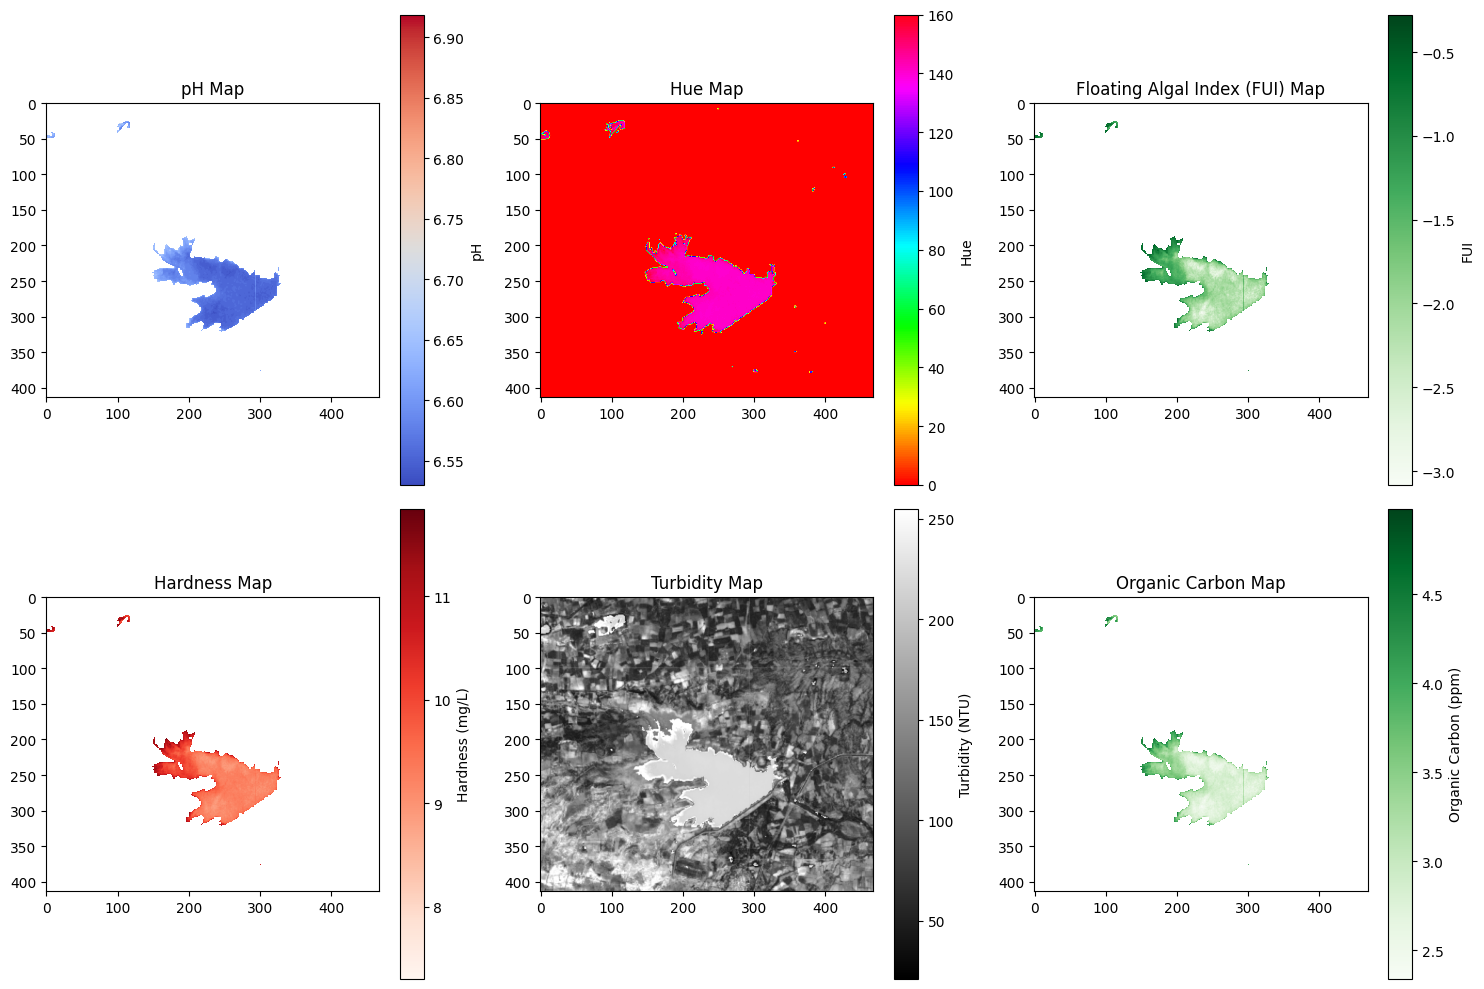

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/tappar_lake.png'  # Update the path to your image file
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB and HSV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a mask for water regions (adjust HSV range based on your data)
lower_purple = np.array([120, 50, 50])  # Adjust based on water color
upper_purple = np.array([160, 255, 255])
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# --- pH Calculation ---
blue_band = image_rgb[:, :, 2]  # Blue channel
nir_band = np.ones_like(blue_band) * 100  # Substitute NIR band with a constant value
nir_band = np.clip(nir_band, 1, None)  # Avoid divide-by-zero
ratio = blue_band.astype(float) / nir_band
pH = 8.399 - 0.827 * ratio
pH[mask == 0] = np.nan  # Mask non-water regions
average_pH = np.nanmean(pH)

# --- Hue Calculation ---
hue = hsv_image[:, :, 0]  # Extract hue channel
masked_hue = cv2.bitwise_and(hue, hue, mask=mask)
average_hue = np.nanmean(masked_hue[mask != 0])

# --- Floating Algal Index (FUI) Calculation ---
green_band = image_rgb[:, :, 1]  # Green channel
fui = (green_band.astype(float) - blue_band) / (green_band + blue_band + 1e-5)
fui[mask == 0] = np.nan  # Mask non-water regions
average_fui = np.nanmean(fui)

# --- Hardness Calculation (using red channel) ---
red_band = image_rgb[:, :, 0]
hardness = red_band.astype(float) * 0.05  # Scaling factor for demonstration
hardness[mask == 0] = np.nan  # Mask non-water regions
average_hardness = np.nanmean(hardness)

# --- Turbidity Calculation (using variance in HSV Value channel) ---
value_channel = hsv_image[:, :, 2]  # Value channel from HSV
turbidity = np.std(value_channel[mask != 0])  # Standard deviation as a proxy for turbidity

# --- Organic Carbon Calculation (using green channel) ---
organic_carbon = green_band.astype(float) * 0.03  # Scaling factor for demonstration
organic_carbon[mask == 0] = np.nan
average_organic_carbon = np.nanmean(organic_carbon)

# Display the results
print(f"Average pH of the water: {average_pH:.2f}")
print(f"Average Hue of the water: {average_hue:.2f}")
print(f"Average FUI of the water: {average_fui:.2f}")
print(f"Average Hardness: {average_hardness:.2f} mg/L")
print(f"Average Turbidity: {turbidity:.2f} NTU")
print(f"Average Organic Carbon: {average_organic_carbon:.2f} ppm")

# Visualize the results
plt.figure(figsize=(15, 10))

# pH Map
plt.subplot(2, 3, 1)
plt.imshow(pH, cmap='coolwarm')
plt.colorbar(label='pH')
plt.title('pH Map')

# Hue Map
plt.subplot(2, 3, 2)
plt.imshow(masked_hue, cmap='hsv')
plt.colorbar(label='Hue')
plt.title('Hue Map')

# FUI Map
plt.subplot(2, 3, 3)
plt.imshow(fui, cmap='Greens')
plt.colorbar(label='FUI')
plt.title('Floating Algal Index (FUI) Map')

# Hardness Map
plt.subplot(2, 3, 4)
plt.imshow(hardness, cmap='Reds')
plt.colorbar(label='Hardness (mg/L)')
plt.title('Hardness Map')

# Turbidity Map
plt.subplot(2, 3, 5)
plt.imshow(value_channel, cmap='gray')
plt.colorbar(label='Turbidity (NTU)')
plt.title('Turbidity Map')

# Organic Carbon Map
plt.subplot(2, 3, 6)
plt.imshow(organic_carbon, cmap='Greens')
plt.colorbar(label='Organic Carbon (ppm)')
plt.title('Organic Carbon Map')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np

# Load the image
image_path = '/content/tappar_lake.png'  # Update the path to your image file
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB and HSV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a mask for water regions (adjust HSV range based on your data)
lower_purple = np.array([120, 50, 50])  # Adjust based on water color
upper_purple = np.array([160, 255, 255])
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# --- pH Calculation ---
blue_band = image_rgb[:, :, 2]  # Blue channel
nir_band = np.ones_like(blue_band) * 100  # Substitute NIR band with a constant value
nir_band = np.clip(nir_band, 1, None)  # Avoid divide-by-zero
ratio = blue_band.astype(float) / nir_band
pH = 8.399 - 0.827 * ratio
pH[mask == 0] = np.nan  # Mask non-water regions
average_pH = np.nanmean(pH)

# --- Hue Calculation ---
hue = hsv_image[:, :, 0]  # Extract hue channel
masked_hue = cv2.bitwise_and(hue, hue, mask=mask)
average_hue = np.nanmean(masked_hue[mask != 0])

# --- Floating Algal Index (FUI) Calculation ---
green_band = image_rgb[:, :, 1]  # Green channel
fui = (green_band.astype(float) - blue_band) / (green_band + blue_band + 1e-5)
fui[mask == 0] = np.nan  # Mask non-water regions
average_fui = np.nanmean(fui)

# --- Hardness Calculation (using red channel) ---
red_band = image_rgb[:, :, 0]
hardness = red_band.astype(float) * 0.05  # Scaling factor for demonstration
hardness[mask == 0] = np.nan  # Mask non-water regions
average_hardness = np.nanmean(hardness)

# --- Turbidity Calculation (using variance in HSV Value channel) ---
value_channel = hsv_image[:, :, 2]  # Value channel from HSV
turbidity = np.std(value_channel[mask != 0])  # Standard deviation as a proxy for turbidity

# --- Organic Carbon Calculation (using green channel) ---
organic_carbon = green_band.astype(float) * 0.03  # Scaling factor for demonstration
organic_carbon[mask == 0] = np.nan
average_organic_carbon = np.nanmean(organic_carbon)

# Display the results
print(f"Average pH of the water: {average_pH:.2f}")
print(f"Average Hue of the water: {average_hue:.2f}")
print(f"Average FUI of the water: {average_fui:.2f}")
print(f"Average Hardness: {average_hardness:.2f} mg/L")
print(f"Average Turbidity: {turbidity:.2f} NTU")
print(f"Average Organic Carbon: {average_organic_carbon:.2f} ppm")


Average pH of the water: 6.58
Average Hue of the water: 143.88
Average FUI of the water: -1.74
Average Hardness: 9.70 mg/L
Average Turbidity: 3.70 NTU
Average Organic Carbon: 3.18 ppm


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/tappar_lake.png'  # Update the path to your image file
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB and HSV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a mask for water regions (adjust HSV range based on your data)
lower_purple = np.array([120, 50, 50])  # Adjust based on water color
upper_purple = np.array([160, 255, 255])
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# --- pH Calculation ---
blue_band = image_rgb[:, :, 2]  # Blue channel
nir_band = np.ones_like(blue_band) * 100  # Substitute NIR band with a constant value
nir_band = np.clip(nir_band, 1, None)  # Avoid divide-by-zero
ratio = blue_band.astype(float) / nir_band
pH = 8.399 - 0.827 * ratio
pH[mask == 0] = np.nan  # Mask non-water regions
average_pH = np.nanmean(pH)

# --- Hue Calculation ---
hue = hsv_image[:, :, 0]  # Extract hue channel
masked_hue = cv2.bitwise_and(hue, hue, mask=mask)
average_hue = np.nanmean(masked_hue[mask != 0])

# --- Floating Algal Index (FUI) Calculation ---
green_band = image_rgb[:, :, 1]  # Green channel
fui = (green_band.astype(float) - blue_band) / (green_band + blue_band + 1e-5)
fui[mask == 0] = np.nan  # Mask non-water regions
average_fui = np.nanmean(fui)

# --- Dissolved Oxygen (DO) Calculation ---
# Using the empirical formula DO = a * (Blue/Red) + b
red_band = image_rgb[:, :, 0]  # Red channel
do_ratio = blue_band.astype(float) / (red_band + 1e-5)  # Avoid divide-by-zero
a, b = 2.0, 5.0  # Example coefficients (replace with actual values from calibration)
DO = a * do_ratio + b
DO[mask == 0] = np.nan  # Mask non-water regions
average_DO = np.nanmean(DO)

# --- Hardness Calculation (using red channel) ---
hardness = red_band.astype(float) * 0.05  # Scaling factor for demonstration
hardness[mask == 0] = np.nan  # Mask non-water regions
average_hardness = np.nanmean(hardness)

# --- Turbidity Calculation (using variance in HSV Value channel) ---
value_channel = hsv_image[:, :, 2]  # Value channel from HSV
turbidity = np.std(value_channel[mask != 0])  # Standard deviation as a proxy for turbidity

# --- Organic Carbon Calculation (using green channel) ---
organic_carbon = green_band.astype(float) * 0.03  # Scaling factor for demonstration
organic_carbon[mask == 0] = np.nan
average_organic_carbon = np.nanmean(organic_carbon)

# Display the results without units
print(f"Average pH of the water: {average_pH:.2f}")
print(f"Average Hue of the water: {average_hue:.2f}")
print(f"Average FUI of the water: {average_fui:.2f}")
print(f"Average DO of the water: {average_DO:.2f}")
print(f"Average Hardness: {average_hardness:.2f}")
print(f"Average Turbidity: {turbidity:.2f}")
print(f"Average Organic Carbon: {average_organic_carbon:.2f}")




Average pH of the water: 6.58
Average Hue of the water: 143.88
Average FUI of the water: -1.74
Average DO of the water: 7.28
Average Hardness: 9.70
Average Turbidity: 3.70
Average Organic Carbon: 3.18


In [ ]:
import cv2
import numpy as np

# Load the image
image_path = '/content/tappar_lake.png'  # Update the path to your image file
image = cv2.imread(image_path)

# Check if the image loaded correctly
if image is None:
    raise FileNotFoundError(f"Failed to load image from {image_path}. Check the file path.")

# Convert the image to RGB and HSV
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a mask for water regions (adjust HSV range based on your data)
lower_purple = np.array([120, 50, 50])  # Adjust based on water color
upper_purple = np.array([160, 255, 255])
mask = cv2.inRange(hsv_image, lower_purple, upper_purple)

# --- pH Calculation ---
blue_band = image_rgb[:, :, 2]  # Blue channel
nir_band = np.ones_like(blue_band) * 100  # Substitute NIR band with a constant value
nir_band = np.clip(nir_band, 1, None)  # Avoid divide-by-zero
ratio = blue_band.astype(float) / nir_band
pH = 8.399 - 0.827 * ratio
pH[mask == 0] = np.nan  # Mask non-water regions
average_pH = np.nanmean(pH)

# --- Hue Calculation ---
hue = hsv_image[:, :, 0]  # Extract hue channel
masked_hue = cv2.bitwise_and(hue, hue, mask=mask)
average_hue = np.nanmean(masked_hue[mask != 0])

# --- Floating Algal Index (FUI) Calculation ---
green_band = image_rgb[:, :, 1]  # Green channel
fui = (green_band.astype(float) - blue_band) / (green_band + blue_band + 1e-5)
fui[mask == 0] = np.nan  # Mask non-water regions
average_fui = np.nanmean(fui)

# --- Hardness Calculation (using red channel) ---
red_band = image_rgb[:, :, 0]
hardness = red_band.astype(float) * 0.05  # Scaling factor for demonstration
hardness[mask == 0] = np.nan  # Mask non-water regions
average_hardness = np.nanmean(hardness)

# --- Turbidity Calculation (using variance in HSV Value channel) ---
value_channel = hsv_image[:, :, 2]  # Value channel from HSV
turbidity = np.std(value_channel[mask != 0])  # Standard deviation as a proxy for turbidity

# --- Organic Carbon Calculation (using green channel) ---
organic_carbon = green_band.astype(float) * 0.03  # Scaling factor for demonstration
organic_carbon[mask == 0] = np.nan
average_organic_carbon = np.nanmean(organic_carbon)

# Display the results without units
print(f"Average pH of the water: {average_pH:.2f}")
print(f"Average Hue of the water: {average_hue:.2f}")
print(f"Average FUI of the water: {average_fui:.2f}")
print(f"Average Hardness: {average_hardness:.2f}")
print(f"Average Turbidity: {turbidity:.2f}")
print(f"Average Organic Carbon: {average_organic_carbon:.2f}")


Average pH of the water: 6.58
Average Hue of the water: 143.88
Average FUI of the water: -1.74
Average Hardness: 9.70
Average Turbidity: 3.70
Average Organic Carbon: 3.18


In [ ]:
import pandas as pd
data=pd.read_csv('/content/water_potability.csv')
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Choose the specific columns you want (pH, Hardness, Organic Carbon, Turbidity, and Potability)
columns_to_select = ['ph', 'Hardness', 'Organic_carbon', 'Turbidity', 'Potability']

# Extract only those columns
data = data[columns_to_select]

In [ ]:
data.head()

,ph,Hardness,Organic_carbon,Turbidity,Potability
0,NaN,204.890455,10.379783,2.963135,0
1,3.716080,129.422921,15.180013,4.500656,0
2,8.099124,224.236259,16.868637,3.055934,0
3,8.316766,214.373394,18.436524,4.628771,0
4,9.092223,181.101509,11.558279,4.075075,0


In [ ]:
data.isnull().sum()

,0
ph,491
Hardness,0
Organic_carbon,0
Turbidity,0
Potability,0


In [ ]:
data.shape

(3276, 5)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isnull().sum()

,0
ph,0
Hardness,0
Organic_carbon,0
Turbidity,0
Potability,0


In [ ]:
data.drop_duplicates(inplace=True)

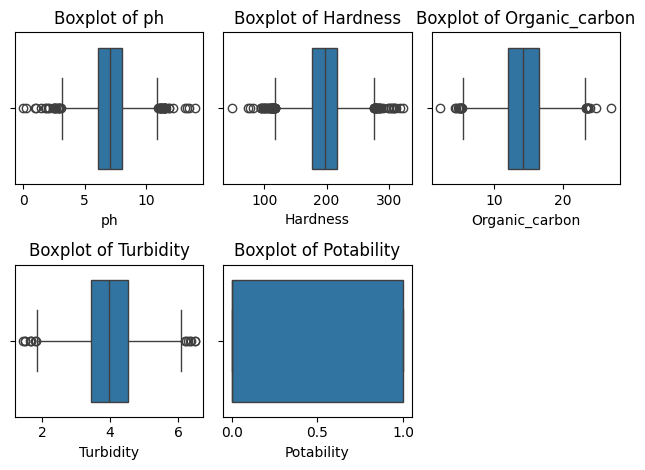

In [ ]:
# Specify the columns you want to plot (if you want to use all columns, just use df.columns)
import matplotlib.pyplot as plt
import seaborn as sns
columns_to_plot = ['ph', 'Hardness', 'Organic_carbon', 'Turbidity', 'Potability']
# Loop over the selected columns and create a box plot for each
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid of plots (adjust depending on the number of columns)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

In [ ]:
# Loop through each column in the dataset and print its value counts
for column in data.columns:
    print(f"Value counts for {column}:")
    print(data[column].value_counts())
    print("\n" + "-"*50 + "\n")

Value counts for ph:
ph
3.716080    1
6.704432    1
5.915807    1
8.136498    1
6.493764    1
           ..
7.808012    1
5.895949    1
7.269652    1
9.489601    1
7.874671    1
Name: count, Length: 2785, dtype: int64

--------------------------------------------------

Value counts for Hardness:
Hardness
129.422921    1
148.842129    1
195.744074    1
184.231854    1
205.150564    1
             ..
179.799917    1
187.153617    1
155.157520    1
167.887629    1
195.102299    1
Name: count, Length: 2785, dtype: int64

--------------------------------------------------

Value counts for Organic_carbon:
Organic_carbon
15.180013    1
20.794371    1
21.300647    1
15.288782    1
12.164736    1
            ..
12.092499    1
11.410184    1
17.385515    1
14.168314    1
16.140368    1
Name: count, Length: 2785, dtype: int64

--------------------------------------------------

Value counts for Turbidity:
Turbidity
4.500656    1
3.395332    1
4.513201    1
4.204186    1
4.910911    1
          

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2785 entries, 1 to 3275
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ph              2785 non-null   float64
 1   Hardness        2785 non-null   float64
 2   Organic_carbon  2785 non-null   float64
 3   Turbidity       2785 non-null   float64
 4   Potability      2785 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 130.5 KB


In [ ]:
data.describe()

,ph,Hardness,Organic_carbon,Turbidity,Potability
count,2785.000000,2785.000000,2785.000000,2785.000000,2785.000000
mean,7.080795,196.281206,14.308514,3.970230,0.395332
std,1.594320,32.940796,3.304141,0.784964,0.489010
min,0.000000,47.432000,2.200000,1.450000,0.000000
25%,6.093092,176.841063,12.095251,3.440859,0.000000
50%,7.036752,197.076934,14.252684,3.958543,0.000000
75%,8.062066,216.622392,16.574190,4.515150,1.000000
max,14.000000,323.124000,27.006707,6.494749,1.000000


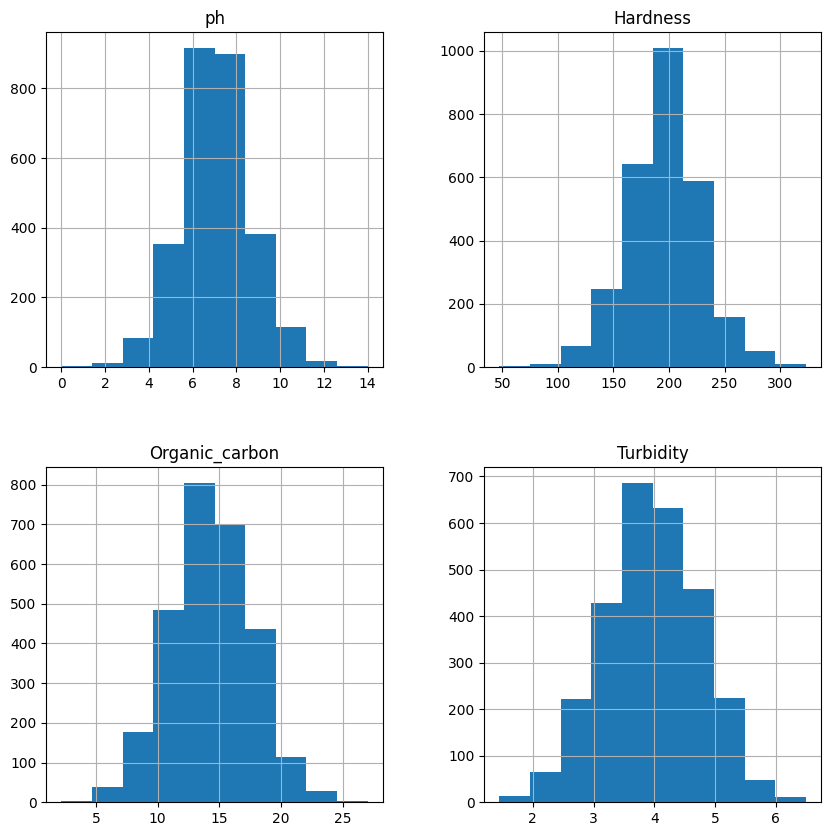

In [ ]:
#Histograms
fig = plt.figure(figsize = (10,10))
var = data.drop("Potability", axis=1)
ax = fig.gca()
var.hist(ax=ax)
plt.show();

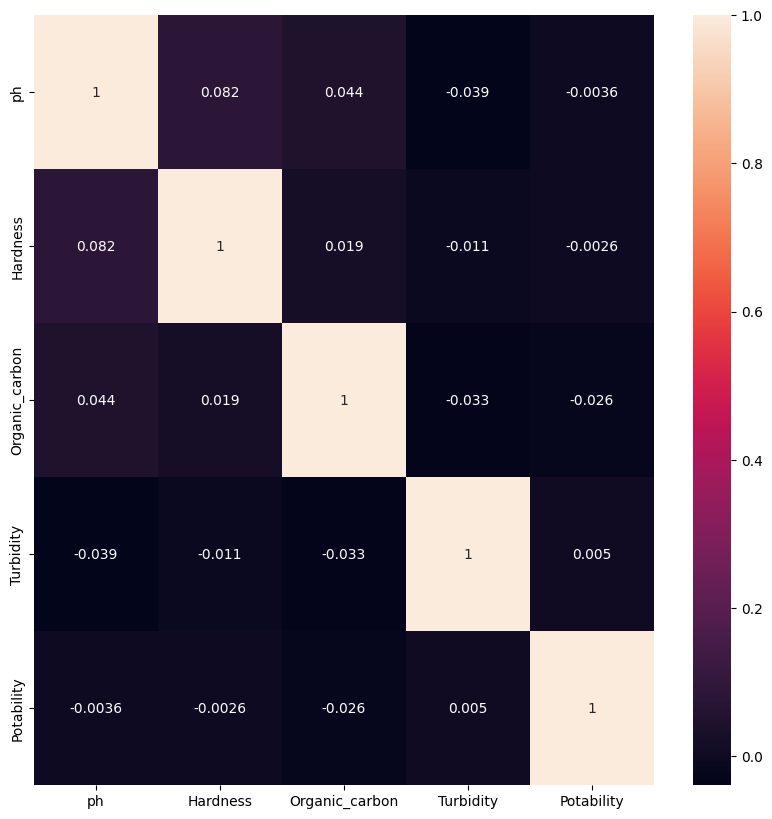

In [ ]:
#hEAT MAP
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,fmt=".2g")
plt.show()

In [ ]:
data.corr()

,ph,Hardness,Organic_carbon,Turbidity,Potability
ph,1.000000,0.082096,0.043503,-0.039057,-0.003556
Hardness,0.082096,1.000000,0.018870,-0.010512,-0.002595
Organic_carbon,0.043503,0.018870,1.000000,-0.033048,-0.025777
Turbidity,-0.039057,-0.010512,-0.033048,1.000000,0.005025
Potability,-0.003556,-0.002595,-0.025777,0.005025,1.000000


In [ ]:
# Model Algorithm
import numpy as np

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn import tree

#miscellaneous
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data.columns

Index(['ph', 'Hardness', 'Organic_carbon', 'Turbidity', 'Potability'], dtype='object')

In [ ]:
data['Potability'].value_counts()

,count
Potability,
0,1684
1,1101


<Axes: xlabel='Potability', ylabel='count'>

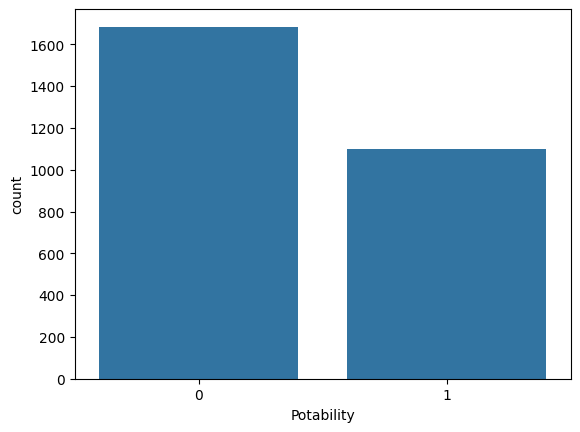

In [ ]:
sns.countplot(x='Potability', data=data)

In [ ]:
data['Potability'].value_counts()

,count
Potability,
0,1684
1,1101


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Balancing the target column
ros = RandomOverSampler(random_state=42)
_, data['Potability'] = ros.fit_resample(data.drop('Potability', axis=1), data['Potability'])


In [ ]:
data['Potability'].value_counts()

,count
Potability,
0,1413
1,1372


In [ ]:
x = data.drop("Potability", axis=1)
y = data.Potability
X_train , X_test , y_train , y_test = train_test_split(x , y, test_size=0.25, random_state=42)

# **ALGORITHMS**


In [ ]:
df=data.copy()

**KNN IMPLEMENTATION**

In [ ]:
X = df.drop(['Potability'],axis=1)
Y = df['Potability']
X_stdscle = StandardScaler().fit_transform(X.values)

In [ ]:
#training the KNN model and predicting the classes
X_stdscle_df = pd.DataFrame(X_stdscle, index=X.index, columns=X.columns)
x_train, x_test, y_train, y_test = train_test_split(X_stdscle_df,Y,test_size=0.3, random_state =1)
knn_clf = KNeighborsClassifier(n_neighbors =5,p=2,metric='minkowski')
knn_clf.fit(x_train,y_train)

KNeighborsClassifier()

In [ ]:

#printing the accuracy and all other scores

print("Train Accuracy : ", 100*(round(accuracy_score(y_train,knn_clf.predict(x_train)),5)))
print("Test Accuracy : ", 100*(round(accuracy_score(y_test,knn_clf.predict(x_test)),5)))
result = confusion_matrix(y_test, knn_clf.predict(x_test))
print("Confusion Matrix:")
print(result)
print("Classification Report : \n", classification_report(y_test, knn_clf.predict(x_test)))

Train Accuracy :  67.984
Test Accuracy :  50.836999999999996
Confusion Matrix:
[[220 185]
 [226 205]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.49      0.54      0.52       405
           1       0.53      0.48      0.50       431

    accuracy                           0.51       836
   macro avg       0.51      0.51      0.51       836
weighted avg       0.51      0.51      0.51       836



In [ ]:
#training the KNN model and predicting the classes
X_stdscle_df = pd.DataFrame(X_stdscle, index=X.index, columns=X.columns)
x_train, x_test, y_train, y_test = train_test_split(X_stdscle_df,Y,test_size=0.3, random_state =1)
knn_clf = KNeighborsClassifier(n_neighbors = 3,p=2,metric='minkowski')
knn_clf.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#printing the accuracy and all other scores
print("Train Accuracy : ", 100*(round(accuracy_score(y_train,knn_clf.predict(x_train)),5)))
print("Test Accuracy : ", 100*(round(accuracy_score(y_test,knn_clf.predict(x_test)),5)))
result = confusion_matrix(y_test, knn_clf.predict(x_test))
print("Confusion Matrix:")
print(result)
print("Classification Report : \n", classification_report(y_test, knn_clf.predict(x_test)))

Train Accuracy :  74.089
Test Accuracy :  48.684
Confusion Matrix:
[[205 200]
 [229 202]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.47      0.51      0.49       405
           1       0.50      0.47      0.48       431

    accuracy                           0.49       836
   macro avg       0.49      0.49      0.49       836
weighted avg       0.49      0.49      0.49       836



In [ ]:

#training the KNN model and predicting the classes
X_stdscle_df = pd.DataFrame(X_stdscle, index=X.index, columns=X.columns)
x_train, x_test, y_train, y_test = train_test_split(X_stdscle_df,Y,test_size=0.3, random_state =1)
knn_clf = KNeighborsClassifier(n_neighbors = 2,p=1,metric='minkowski')
knn_clf.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=2, p=1)

In [ ]:

#printing the accuracy and all other scores

print("Train Accuracy : ", 100*(round(accuracy_score(y_train,knn_clf.predict(x_train)),5)))
print("Test Accuracy : ", 100*(round(accuracy_score(y_test,knn_clf.predict(x_test)),5)))
result = confusion_matrix(y_test, knn_clf.predict(x_test))
print("Confusion Matrix:")
print(result)
print("Classification Report : \n", classification_report(y_test, knn_clf.predict(x_test)))

Train Accuracy :  73.833
Test Accuracy :  47.727000000000004
Confusion Matrix:
[[309  96]
 [341  90]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.48      0.76      0.59       405
           1       0.48      0.21      0.29       431

    accuracy                           0.48       836
   macro avg       0.48      0.49      0.44       836
weighted avg       0.48      0.48      0.43       836



In [ ]:
#MSE
from sklearn.metrics import mean_squared_error
print("MSE:",mean_squared_error(y_test, knn_clf.predict(x_test)))

# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, knn_clf.predict(x_test))))

#MAE
from sklearn.metrics import mean_absolute_error
print("MAE:",mean_absolute_error(y_test, knn_clf.predict(x_test)))

#R2
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test, knn_clf.predict(x_test)))

MSE: 0.5227272727272727
RMSE: 0.7229988054812212
MAE: 0.5227272727272727
R2: -1.0929334593681075


Text(50.722222222222214, 0.5, 'Prediction Label')

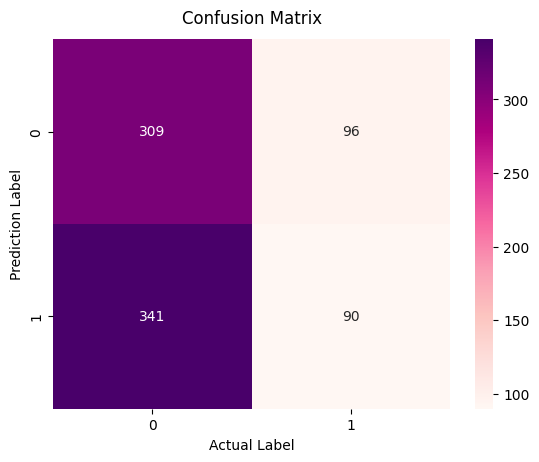

In [ ]:
sns.heatmap(data=confusion_matrix(y_test, knn_clf.predict(x_test)), annot = True, cmap="RdPu",fmt='g')
plt.title('Confusion Matrix', y=1.02)
plt.xlabel('Actual Label')
plt.ylabel('Prediction Label')

**DECISION TREE** **IMPLEMENTATION**

In [ ]:
# Create Decision tree classifier object
clf = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best')

# Train Decision Tree Classifier
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)
acc_decision_tree = round(clf.score(x_train, y_train) * 100, 2)

#Model Accuracy, how often is the classifier correct?
print("Train accuracy:",acc_decision_tree)
print("Test Accuracy:", 100*(metrics.accuracy_score(y_test, y_pred)))

result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print("Classification Report : \n", classification_report(y_test, y_pred))


Train accuracy: 52.95
Test Accuracy: 49.40191387559808
Confusion Matrix:
[[396   9]
 [414  17]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.49      0.98      0.65       405
           1       0.65      0.04      0.07       431

    accuracy                           0.49       836
   macro avg       0.57      0.51      0.36       836
weighted avg       0.57      0.49      0.35       836



In [ ]:
# Create Decision tree classifier object
clf = DecisionTreeClassifier(criterion='entropy',max_depth=12,splitter='random')

# Train Decision Tree Classifier
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)
acc_decision_tree = round(clf.score(x_train, y_train) * 100, 2)

#Model Accuracy, how often is the classifier correct?
print("Train accuracy:",acc_decision_tree)
print("Test Accuracy:", 100*(metrics.accuracy_score(y_test, y_pred)))

result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print("Classification Report : \n", classification_report(y_test, y_pred))

Train accuracy: 63.31
Test Accuracy: 49.760765550239235
Confusion Matrix:
[[269 136]
 [284 147]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.49      0.66      0.56       405
           1       0.52      0.34      0.41       431

    accuracy                           0.50       836
   macro avg       0.50      0.50      0.49       836
weighted avg       0.50      0.50      0.48       836



In [ ]:
# Create Decision tree classifier object
clf = DecisionTreeClassifier(criterion='entropy',max_depth=12,splitter='best')

# Train Decision Tree Classifier
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)
acc_decision_tree = round(clf.score(x_train, y_train) * 100, 2)

#Model Accuracy, how often is the classifier correct?
print("Train accuracy:",acc_decision_tree)
print("Test Accuracy:", 100*(metrics.accuracy_score(y_test, y_pred)))

result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
print("Classification Report : \n", classification_report(y_test, y_pred))

Train accuracy: 65.93
Test Accuracy: 52.511961722488046
Confusion Matrix:
[[195 210]
 [187 244]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.51      0.48      0.50       405
           1       0.54      0.57      0.55       431

    accuracy                           0.53       836
   macro avg       0.52      0.52      0.52       836
weighted avg       0.52      0.53      0.52       836



In [ ]:
#MSE
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#MAE
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

#R2
from sklearn.metrics import r2_score
print(r2_score(y_test,y_pred))

0.4748803827751196
0.6891156526847432
0.4748803827751196
-0.9013606026753744


Text(50.722222222222214, 0.5, 'Prediction Label')

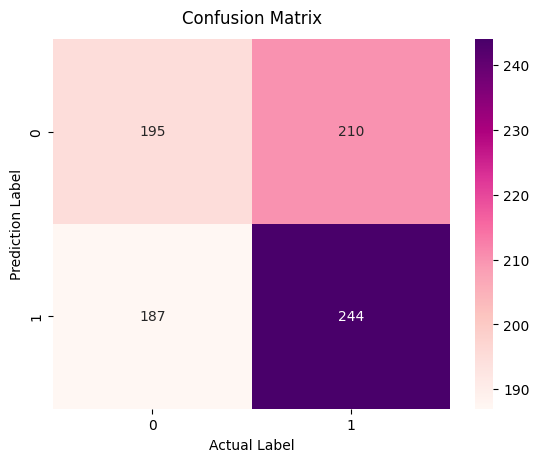

In [ ]:
sns.heatmap(data=confusion_matrix(y_test, clf.predict(x_test)), annot = True, cmap="RdPu",fmt='g')
plt.title('Confusion Matrix', y=1.02)
plt.xlabel('Actual Label')
plt.ylabel('Prediction Label')

**RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 150,criterion='entropy',max_depth = 10)
classifier.fit(x_train, y_train)
rf_pred = classifier.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, rf_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,rf_pred)*100
print("Accuracy:",result2)

Confusion Matrix:
[[270 135]
 [242 189]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       405
           1       0.58      0.44      0.50       431

    accuracy                           0.55       836
   macro avg       0.56      0.55      0.54       836
weighted avg       0.56      0.55      0.54       836

Accuracy: 54.90430622009569


In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 500,criterion='entropy',max_depth = 8)
classifier.fit(x_train, y_train)
rf_pred = classifier.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, rf_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,rf_pred)*100
print("Accuracy:",result2)

Confusion Matrix:
[[273 132]
 [249 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.67      0.59       405
           1       0.58      0.42      0.49       431

    accuracy                           0.54       836
   macro avg       0.55      0.55      0.54       836
weighted avg       0.55      0.54      0.54       836

Accuracy: 54.42583732057417


In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100,criterion='entropy',max_depth = None)
classifier.fit(x_train, y_train)
rf_pred = classifier.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, rf_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,rf_pred)*100
print("Accuracy:",result2)

Confusion Matrix:
[[243 162]
 [224 207]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       405
           1       0.56      0.48      0.52       431

    accuracy                           0.54       836
   macro avg       0.54      0.54      0.54       836
weighted avg       0.54      0.54      0.54       836

Accuracy: 53.827751196172244


In [ ]:
#MSE
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, rf_pred))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, rf_pred)))

#MAE
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, rf_pred))

#R2
from sklearn.metrics import r2_score
print(r2_score(y_test,rf_pred))

0.46172248803827753
0.6795016468252874
0.46172248803827753
-0.848678067084873


Text(50.722222222222214, 0.5, 'Prediction Label')

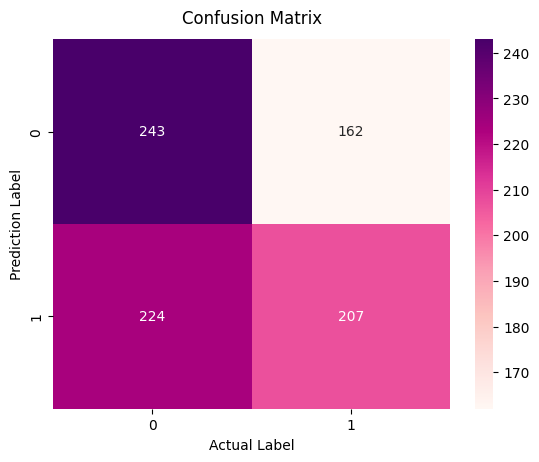

In [ ]:
sns.heatmap(data=confusion_matrix(y_test, classifier.predict(x_test)), annot = True, cmap="RdPu",fmt='g')
plt.title('Confusion Matrix', y=1.02)
plt.xlabel('Actual Label')
plt.ylabel('Prediction Label')

Text(50.722222222222214, 0.5, 'Prediction Label')

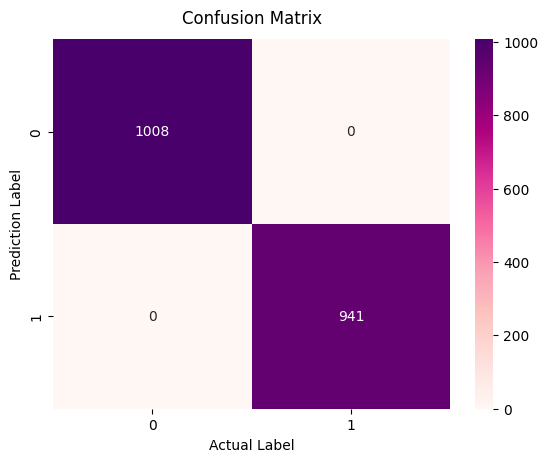

In [ ]:
sns.heatmap(data=confusion_matrix(y_train, classifier.predict(x_train)), annot = True, cmap="RdPu",fmt='g')
plt.title('Confusion Matrix', y=1.02)
plt.xlabel('Actual Label')
plt.ylabel('Prediction Label')

**STOCHASTIC GRADIENT DESCENT**

In [ ]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)
sgd_pred = sgd.predict(x_test)
acc_sgd = round(sgd.score(x_train, y_train) * 100, 2)
test_acc_sgd = round(sgd.score(x_test, sgd_pred) * 100, 2)
print('Accuracy on training data : ', acc_sgd)
print('Accuracy on test data : ', test_acc_sgd)
result = confusion_matrix(y_test,sgd_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, sgd_pred)
print("Classification Report:",)
print (result1)

Accuracy on training data :  49.31
Accuracy on test data :  100.0
Confusion Matrix:
[[197 208]
 [200 231]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.49      0.49       405
           1       0.53      0.54      0.53       431

    accuracy                           0.51       836
   macro avg       0.51      0.51      0.51       836
weighted avg       0.51      0.51      0.51       836



In [ ]:
#MSE
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, sgd_pred))

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, sgd_pred)))

#MAE
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, sgd_pred))

#R2
from sklearn.metrics import r2_score
print(r2_score(y_test,sgd_pred))

0.4880382775119617
0.6985973643751898
0.4880382775119617
-0.9540431382658761


**CatBOOST**

In [ ]:
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the CatBoost model
cb_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_seed=42)

# Train the model
cb_model.fit(x_train, y_train)

# Predictions on test data
cb_pred = cb_model.predict(x_test)

# Accuracy on training data
acc_cb = round(cb_model.score(x_train, y_train) * 100, 2)

# Accuracy on test data
test_acc_cb = round(cb_model.score(x_test, y_test) * 100, 2)

# Print accuracies
print('CatBoost - Accuracy on training data:', acc_cb)
print('CatBoost - Accuracy on test data:', test_acc_cb)

# Confusion matrix
cb_result = confusion_matrix(y_test, cb_pred)
print("\nCatBoost - Confusion Matrix:")
print(cb_result)

# Classification report
cb_result1 = classification_report(y_test, cb_pred)
print("\nCatBoost - Classification Report:")
print(cb_result1)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00
CatBoost - Accuracy on training data: 71.06
CatBoost - Accuracy on test data: 51.67

CatBoost - Confusion Matrix:
[[253 152]
 [252 179]]

CatBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.56       405
           1       0.54      0.42      0.47       431

    accuracy                           0.52       836
   macro avg       0.52      0.52      0.51       836
weighted avg       0.52      0.52      0.51       836



- Selecting the Random Forest for finetune as we got a very good accuracy on it

Finetune

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
classifier = RandomForestClassifier(random_state=42)

# Set the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200],              # Number of trees in the forest
    'max_depth': [5, 10, 15, None],                # Maximum depth of the tree
    'criterion': ['gini', 'entropy']          # Split criterion                 # Whether bootstrap samples are used
}

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best estimator found by GridSearchCV to make predictions
best_classifier = grid_search.best_estimator_

# Predictions on test data using the best model
rf_pred = best_classifier.predict(x_test)

# Accuracy on training and test data
acc_rf = round(best_classifier.score(x_train, y_train) * 100, 2)
test_acc_rf = round(best_classifier.score(x_test, y_test) * 100, 2)

print('Random Forest - Accuracy on training data:', acc_rf)
print('Random Forest - Accuracy on test data:', test_acc_rf)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
Random Forest - Accuracy on training data: 69.06
Random Forest - Accuracy on test data: 53.47
